<a href="https://colab.research.google.com/github/Bakame1/Handwritten_Digit_Pytorch_CNN/blob/main/Handwritten_Digit_Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn                     # Pour construire les couches du réseau de neurones
import torch.optim as optim               # Pour les optimiseurs (ex: Adam)
import torch.nn.functional as F           # Pour les fonctions d'activation (ex: ReLU)
import torchvision
import torchvision.transforms as transforms # Pour transformer les données (ex: image en Tenseur)
from torch.utils.data import DataLoader   # Pour charger les données par lots (batches)



## Préparer les données (MNIST)

In [2]:
# Transformation : Convertir les images en Tenseurs PyTorch
transform = transforms.ToTensor()

# Télécharger le jeu de données d'entraînement
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
# Créer un chargeur de données pour l'entraînement (par lots de 64)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Télécharger le jeu de données de test
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
# Créer un chargeur de données pour le test
testloader = DataLoader(testset, batch_size=64, shuffle=False)



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.08MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.49MB/s]


## Définir le petit CNN

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 1. Couche de convolution :
        #Prend 1 canal d'entrée (image en noir et blanc)
        #Produit 10 canaux de sortie (10 "filtres")
        #Taille du noyau (filtre) = 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)

        # 2. Couche de Max Pooling :
        #    Réduit la taille de l'image (par 2) pour garder l'essentiel
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Couche linéaire (entièrement connectée) :
        #Les images (après conv + pool) sont "aplaties" (flatten)
        #La taille d'entrée est 10 (canaux) * 12 * 12 (taille de l'image réduite)
        #La taille de sortie est 10, car nous avons 10 classes (chiffres 0-9)
        self.fc1 = nn.Linear(in_features=10 * 12 * 12, out_features=10)

    def forward(self, x):
        # Définit comment les données passent à travers les couches

        #Applique Conv1, puis ReLU (activation), puis Pooling
        #x shape: [64, 1, 28, 28] (batch, canal, hauteur, largeur)
        x = self.pool(F.relu(self.conv1(x)))
        #x shape: [64, 10, 12, 12]

        #Aplatir le tenseur pour la couche linéaire
        #-1 signifie "calcule la taille de cette dimension automatiquement"
        x = torch.flatten(x, 1) # Aplatit tout sauf la dimension 0 (le batch)
        #x shape: [64, 1440] (où 1440 = 10*12*12)

        # Appliquer la couche linéaire
        x = self.fc1(x)
        # x shape: [64, 10]

        return x

## Entraîner le modèle

In [4]:
# Créer une instance de notre modèle
model = SimpleCNN()

# Définir la fonction de perte (Loss)
# On choisit CrossEntropyLoss car c'est un standard pour la classification.
# Elle combine Softmax et la perte.
criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur (comment le modèle apprend)
# On teste avec Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Début de l'entraînement...")
num_epochs = 3 #On fait 3 passages complets sur les données

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # 1. Obtenir les données : un lot (batch) d'images et leurs étiquettes
        inputs, labels = data

        # 2. Zéro-iser les gradients (important avant chaque backpropagation)
        optimizer.zero_grad()

        # 3. Forward pass : passer les images dans le modèle
        outputs = model(inputs)

        # 4. Calculer la perte (loss)
        loss = criterion(outputs, labels)

        # 5. Backward pass : calculer les gradients
        loss.backward()

        # 6. Mettre à jour les poids du modèle
        optimizer.step()

        # Afficher les statistiques
        running_loss += loss.item()
        if i % 200 == 199:    # Afficher toutes les 200 mini-batches
            print(f'[Époque {epoch + 1}, Batch {i + 1}] perte: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Entraînement terminé.')



Début de l'entraînement...
[Époque 1, Batch 200] perte: 0.688
[Époque 1, Batch 400] perte: 0.290
[Époque 1, Batch 600] perte: 0.222
[Époque 1, Batch 800] perte: 0.182
[Époque 2, Batch 200] perte: 0.140
[Époque 2, Batch 400] perte: 0.113
[Époque 2, Batch 600] perte: 0.102
[Époque 2, Batch 800] perte: 0.103
[Époque 3, Batch 200] perte: 0.084
[Époque 3, Batch 400] perte: 0.087
[Époque 3, Batch 600] perte: 0.075
[Époque 3, Batch 800] perte: 0.076
Entraînement terminé.


## Évaluer le modèle

In [5]:
correct = 0
total = 0

# Mettre le modèle en mode évaluation
model.eval()

# Pas besoin de calculer les gradients pendant l'évaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Obtenir les prédictions du modèle
        outputs = model(images)

        # torch.max renvoie (valeur_max, index_max)
        # L'index_max (dim=1) est notre prédiction de classe
        _, predicted = torch.max(outputs.data, 1)

        # Mettre à jour le total
        total += labels.size(0)

        # Mettre à jour le nombre de prédictions correctes
        correct += (predicted == labels).sum().item()

# Afficher la précision finale
accuracy = 100 * correct / total
print(f'Précision du modèle sur les 10000 images de test: {accuracy:.2f} %')

Précision du modèle sur les 10000 images de test: 98.06 %


## Test sur 1 image aléatoire

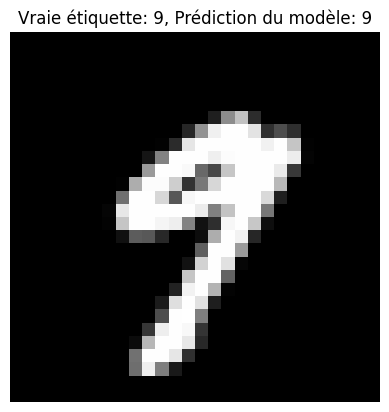

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Mettre le modèle en mode évaluation
model.eval()

# Prendre un lot (batch) d'images et d'étiquettes du jeu de test
dataiter = iter(testloader)
images, labels = next(dataiter)

# Sélectionner une image aléatoire dans le lot
index = np.random.randint(0, len(images))
image = images[index]
label = labels[index]

# Redimensionner l'image pour l'affichage (supprimer la dimension du canal)
image_to_show = image.squeeze().numpy()

# Faire une prédiction avec le modèle
# Ajouter une dimension de lot car le modèle attend un lot d'images (même si un seul)
output = model(image.unsqueeze(0))

# Obtenir la classe prédite
_, predicted = torch.max(output.data, 1)

# Afficher l'image et la prédiction
plt.imshow(image_to_show, cmap='gray')
plt.title(f"Vraie étiquette: {label.item()}, Prédiction du modèle: {predicted.item()}")
plt.axis('off')
plt.show()